# Ray start/stop

In [ ]:
ray.init(ignore_reinit_error=True)

In [ ]:
import ray
ray.shutdown()

# Imports

In [10]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("bokeh_output.html")
# import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# import pdb; pdb.set_trace()
# import pudb; pudb.set_trace()

# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'
# pd.set_option('precision', 2)
# .plot_bokeh(sizing_mode="scale_height")
# .plot_bokeh(kind='hist', bins=1000, sizing_mode="scale_height", xlim=[0, .1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# get clean trades
from bar_sampler.meta import get_clean_trades

tdf, bdf = get_clean_trades('VTI', '2020-01-02', freq='3s')

In [ ]:
# tdf.set_index('nyc_dt').price.plot()

# tdf[['price', 'price_jma']].plot_bokeh(sizing_mode="scale_height")

# bdf.side_volume.plot_bokeh(kind='hist', bins=1000, sizing_mode="scale_height")

# tdf[tdf.mad_outlier==False].set_index('nyc_dt').price.plot()

# (tdf.nyc_dt.shift(-20) - tdf.nyc_dt).describe(percentiles=[.8, .9, .99, .995])

# Sample tick dates

In [4]:
thresh = {
    # meta params
    'symbol': 'VTI',
    'start_date': '2020-01-02',
    'end_date': '2020-01-07',
    # bar sampler params
    'renko_return': 'price_return',
    'renko_size': 0.1,
    'renko_reveral_multiple': 2,
    'renko_range_frac': 22,
    'max_duration_td': dt.timedelta(minutes=33),
    'min_duration_td': dt.timedelta(seconds=33),
    'min_tick_count': 33,
    # label params
    'add_label': True,
    'reward_ratios': list(np.arange(2.5, 11, 0.5)),
    # filter
    'mad_value_winlen': 22,
    'mad_deviation_winlen': 1111,
    'mad_k': 11,
    'jma_winlen': 7,
    'jma_power': 2,
}

In [5]:
from bar_sampler.meta import get_bar_date, get_bar_dates

# bd = get_bar_date(thresh, date='2020-01-02')
bds = get_bar_dates(thresh)

VTI 2020-01-03 trying to get data from local file...
False   0.997034
True    0.002966
Name: mad_outlier, dtype: float64


100%|██████████| 7760/7760 [00:31<00:00, 244.57it/s]


VTI 2020-01-06 trying to get data from local file...
False   0.995446
True    0.004554
Name: mad_outlier, dtype: float64


100%|██████████| 7760/7760 [00:28<00:00, 272.67it/s]


In [7]:
from utilities.pickle import pickle_dump, pickle_load

# bds = pickle_load('/data_tmp/bds_v2.plk')

# bds = pickle_dump('/data_tmp/bds_v2.plk')

52
profit    0.576923
neutral   0.423077
Name: label_outcome, dtype: float64


<AxesSubplot:>

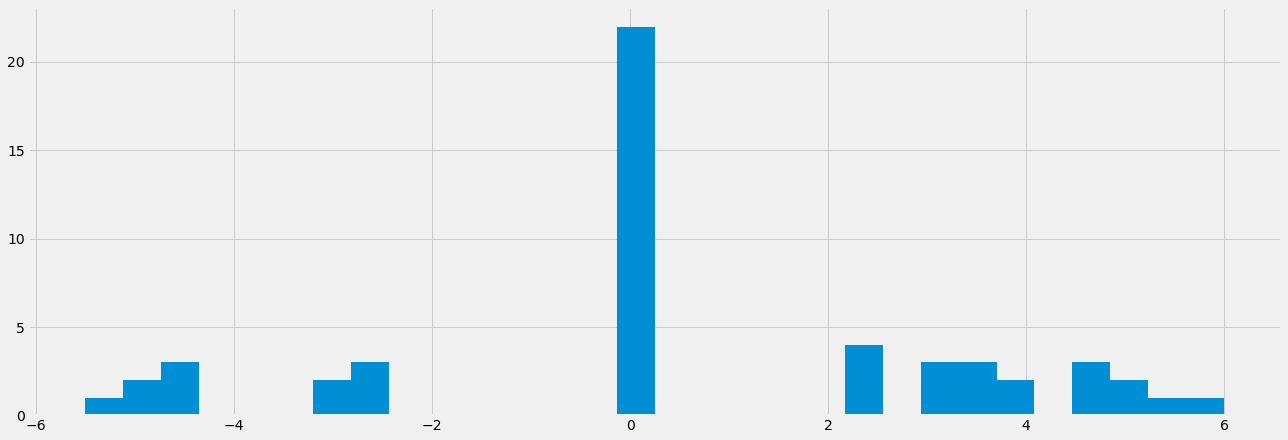

In [11]:
bars_df = bds[0]['bars_df']
print(len(bars_df))
print(bars_df.label_outcome.value_counts()/len(bars_df))
bars_df.label_rrr.hist(bins=30)

In [ ]:
vol_df.set_index('date')[['range', 'range_jma']].plot()

In [ ]:
bars_df[['price_high','price_low', 'price_vwap']].plot_bokeh(sizing_mode="scale_height")

In [13]:
from bar_sampler.stacked import fill_gaps_dates

In [33]:
# bds[0]['bars_df']

In [49]:
# fill daily gaps
stacked_df = fill_gaps_dates(bds, fill_col='price_vwap')

2020-01-06


In [34]:
stacked_df[['price_close','price_vwap']].plot_bokeh(sizing_mode="scale_height")

Figure(id='1200', ...)

In [ ]:
stacked_df.set_index('close_at').price_vwap.plot()

In [ ]:
# stacked stats
stats_df = bm.stacked_df_stats(stacked_df)
stats_df.describe()

stacked_df[['jma_high','jma_low', 'jma_wmean']].plot_bokeh(sizing_mode="scale_height")

In [ ]:
results = []

for date in bar_dates:
    out = (date['ft_ticks_df'].status.value_counts() / date['ft_ticks_df'].shape[0]).to_dict()
    out.update({'date': date['date']})
    results.append(out)

pd.DataFrame(results)